In [1]:
import pandas as pd
import numpy as np

# Cargar datos de conteo desde un archivo CSV
count_data = pd.read_csv('../data/counts_data.csv', index_col=0)

# Crear un DataFrame con la información de las muestras
sample_info = pd.DataFrame({
    'sample_name': count_data.columns,
    'group': ['5xFAD', '5xFAD', 'WT', 'WT']
})
sample_info.set_index('sample_name', inplace=True)
count_data = count_data.T


In [2]:
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats

# Crear el objeto DESeqDataSet
dds = DeseqDataSet(
    counts=count_data,
    metadata=sample_info,
    design_factors="group",
    refit_cooks=True
)

# Realizar el análisis de expresión diferencial
dds.deseq2()


Fitting size factors...
... done in 0.02 seconds.

Fitting dispersions...
... done in 6.62 seconds.

Fitting dispersion trend curve...
... done in 0.75 seconds.

C:\Users\valia\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pydeseq2\dds.py:448: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
  self.fit_dispersion_prior()
Fitting MAP dispersions...
... done in 7.85 seconds.

Fitting LFCs...
... done in 6.03 seconds.

Replacing 0 outlier genes.



In [3]:
results = DeseqStats(dds)
results.summary()
res_df = results.results_df

Running Wald tests...
... done in 5.02 seconds.



Log2 fold change & Wald test p-value: group WT vs 5xFAD
                       baseMean  log2FoldChange     lfcSE      stat    pvalue  \
ENSMUSG00000102693     0.000000             NaN       NaN       NaN       NaN   
ENSMUSG00000064842     0.000000             NaN       NaN       NaN       NaN   
ENSMUSG00000051951     1.486310       -1.040278  1.989794 -0.522807  0.601109   
ENSMUSG00000102851     0.000000             NaN       NaN       NaN       NaN   
ENSMUSG00000103377     0.000000             NaN       NaN       NaN       NaN   
...                         ...             ...       ...       ...       ...   
ENSMUSG00000064368   406.861028        0.297706  0.265044  1.123232  0.261339   
ENSMUSG00000064369     0.741181       -1.042796  2.855329 -0.365210  0.714954   
ENSMUSG00000064370  2965.525840        0.139819  0.204425  0.683961  0.494000   
ENSMUSG00000064371     1.225080        1.955750  2.391653  0.817740  0.413506   
ENSMUSG00000064372    28.914007       -0.169484  0.53

In [4]:
res_df.to_csv('../results/pydeseq2_results.csv')

In [5]:
log_counts = np.log2(count_data + 1)

In [6]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

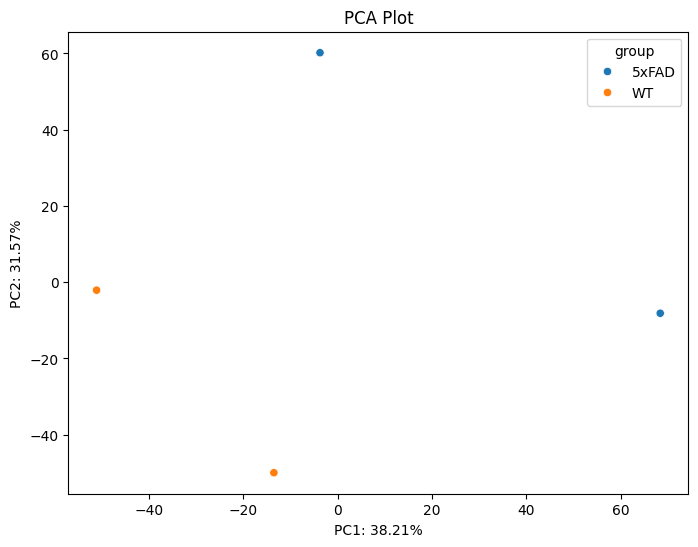

In [7]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(log_counts)
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])
pca_df = pd.concat([pca_df, sample_info.reset_index()], axis=1)
plt.figure(figsize=(8, 6))
sns.scatterplot(x='PC1', y='PC2', hue='group', data=pca_df)
plt.title('PCA Plot')
plt.xlabel(f'PC1: {pca.explained_variance_ratio_[0] * 100:.2f}%')
plt.ylabel(f'PC2: {pca.explained_variance_ratio_[1] * 100:.2f}%')
plt.show()

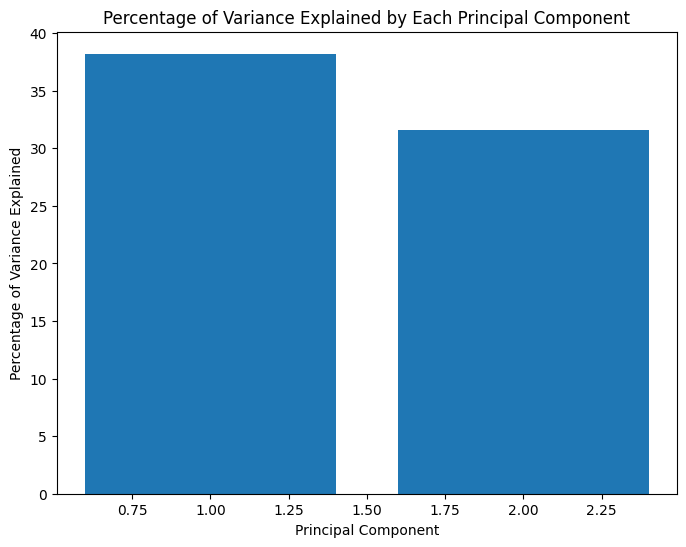

In [8]:
percentVar = pca.explained_variance_ratio_ * 100
plt.figure(figsize=(8, 6))
plt.bar(range(1, len(percentVar) + 1), percentVar)
plt.xlabel('Principal Component')
plt.ylabel('Percentage of Variance Explained')
plt.title('Percentage of Variance Explained by Each Principal Component')
plt.show()

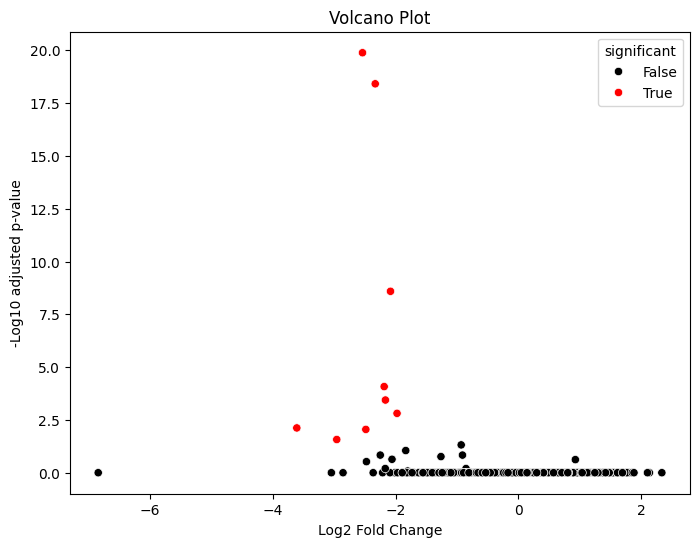

In [9]:
res_df['-log10padj'] = -np.log10(res_df['padj'])
res_df['significant'] = (res_df['padj'] < 0.05) & (abs(res_df['log2FoldChange']) > 1)

plt.figure(figsize=(8, 6))
sns.scatterplot(x='log2FoldChange', y='-log10padj', hue='significant', data=res_df, palette={True: 'red', False: 'black'})
plt.title('Volcano Plot')
plt.xlabel('Log2 Fold Change')
plt.ylabel('-Log10 adjusted p-value')
plt.show()

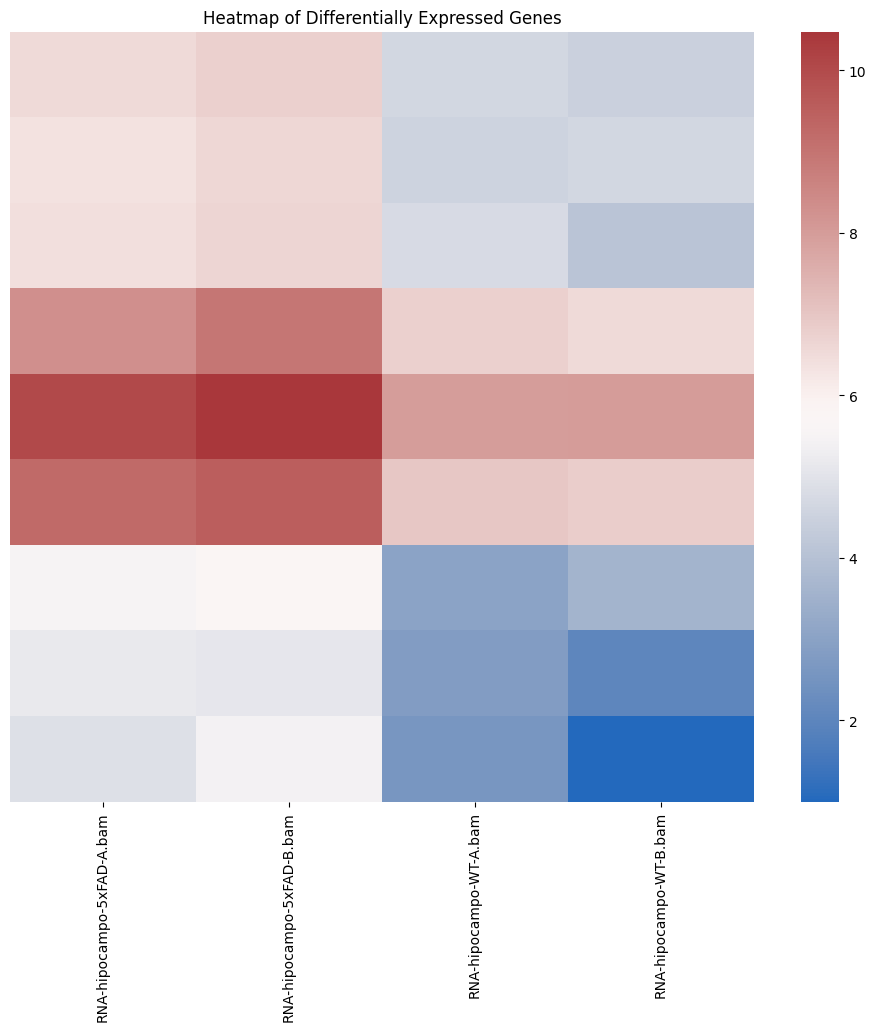

In [10]:
sig_genes = res_df[(res_df['padj'] < 0.05) & (abs(res_df['log2FoldChange']) > 1)].index
heatmap_data = log_counts.loc[:, sig_genes]

plt.figure(figsize=(12, 10))
sns.heatmap(heatmap_data.T, cmap='vlag', yticklabels=False)
plt.title('Heatmap of Differentially Expressed Genes')
plt.show()